# Introduction to Spark Streaming

_____
### Note on  Streaming
Streaming is something that is rapidly advancing and changin fast, there are multipl enew libraries every year, new and different services always popping up, and what is in this notebook may or may not apply to you. Maybe your looking for something specific on Kafka, or maybe you are looking for streaming about twitter, in which case Spark might be overkill for what you really want. Realistically speaking each situation is going to require a customized solution and this course is never going to be able to supply a one size fits all solution. Because of this, I wanted to point out some great resources for Python and Spark StreamingL

* [The Official Documentation is great. This should be your first go to.](http://spark.apache.org/docs/latest/streaming-programming-guide.html#spark-streaming-programming-guide)

* [Fantastic Guide to Spark Streaming with Kafka](https://www.rittmanmead.com/blog/2017/01/getting-started-with-spark-streaming-with-python-and-kafka/)

* [Another Spark Streaming Example with Geo Plotting](http://nbviewer.jupyter.org/github/ibm-cds-labs/spark.samples/blob/master/notebook/DashDB%20Twitter%20Car%202015%20Python%20Notebook.ipynb)
____

Let's discuss SparkStreaming!

Spark Streaming is an extension of the core Spark API that enables scalable, high-throughput, fault-tolerant stream processing of live data streams. Data can be ingested from many sources like Kafka, Flume, Kinesis, or TCP sockets, and can be processed using complex algorithms expressed with high-level functions like map, reduce, join and window. Finally, processed data can be pushed out to filesystems, databases, and live dashboards. In fact, you can apply Spark’s machine learning and graph processing algorithms on data streams.

<img src='http://spark.apache.org/docs/latest/img/streaming-arch.png'/>

Keep in mind that a few of these Streamiing Capabilities are limited when it comes to Python, you'll need to reference the documentation for the most up to date information. Also the streaming contexts tend to follow more along with the older RDD syntax, so a few things might seem different than what we are used to seeing, keep that in mind, you'll definitely want to have a good understanding of lambda expressions before continuing with this!

There are SparkSQL modules for streaming: 

http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=streaming#module-pyspark.sql.streaming

But they are all still listed as experimental, so instead of showing you somethign that might break in the future, we'll stick to the RDD methods (which is what the documentation also currently shows for streaming).

Internally, it works as follows. Spark Streaming receives live input data streams and divides the data into batches, which are then processed by the Spark engine to generate the final stream of results in batches.

<img src='http://spark.apache.org/docs/latest/img/streaming-flow.png'/>

# Twitter Example
In order to use all of this though, we need to setup a Developer API acocunt with Twitter and create an application to get credentials. Review the video for instructions on how to do this or if you are already familiar with it, just get the credentials from: 

    https://apps.twitter.com/
    
Once you have that you also need to install python-twitter, a python library to connect your Python to the twitter dev account.

You probably won't be able to run this example and then previous in the same notebook, you need to restart you kernel.

Let's get started!

Begin by running the TweetRead.py file. Make sure to add your own IP Adress and your credential keys.

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark

In [3]:
# May cause deprecation warnings, safe to ignore, they aren't errors
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [4]:
# Can only run this once. restart your kernel for any errors.
sc = SparkContext()

In [5]:
ssc = StreamingContext(sc, 10 ) # batch_size: batch duration time
sqlContext = SQLContext(sc)

In [6]:
# create a socketTextStream where we will be expecting a Twitter streaming connection
socket_stream = ssc.socketTextStream("127.0.0.1", 5555) # local machine: host, port

In [7]:
# create a DStream via window method on socket_stream
lines = socket_stream.window( 20 ) # 

In [8]:
# Create a class Tweet via namedtuple
from collections import namedtuple
# For every tweet, we want to store its name and count => fields will be tag and count.
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )

In [9]:
# Use Parenthesis for multiple lines or use \.
( lines.flatMap( lambda text: text.split( " " ) ) # Grab the tweet line and split it into a word list.
  .filter( lambda word: word.lower().startswith("#") ) # Check for hashtag calls. Filter the message with the hashtag.
  .map( lambda word: ( word.lower(), 1 ) ) # Convert the words to lowercase.
  .reduceByKey( lambda a, b: a + b ) # Count and remove duplicates.
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Store the words in the Tweet object.
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sort them in a DataFrame.
  .limit(10).registerTempTable("tweets") ) ) #Register to a table. (Refreshes will be executed every 10 seconds.)

__________
### Now run TweetRead_new.py
- At folder containing TweetRead_new.py > type  cmd > python TweetRead_new.py >> tweets_covid_19.txt
- Choose some famous hashtags to check, link: https://www.tweeplers.com/hashtags/?cc=WORLD
__________

In [10]:
#  run the pyspark Stream instance
ssc.start()    

In [11]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
# Only works for Jupyter Notebooks!
%matplotlib inline 

/home/manhcuong/.local/lib/python3.8/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 3650 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/manhcuong/.local/lib/python3.8/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 3617 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/manhcuong/.local/lib/python3.8/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 3648 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/manhcuong/.local/lib/python3.8/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 3604 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/manhcuong/.local/lib/python3.8/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 3629 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/manhcuong/.local/lib/python3.8/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 3619 

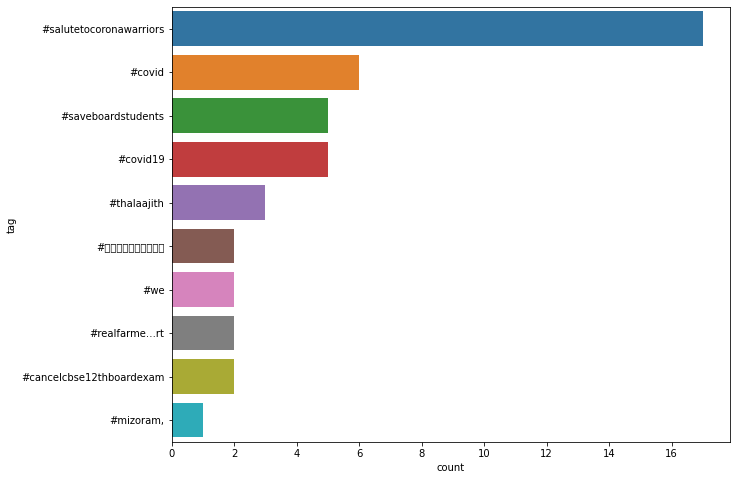

In [12]:
# Make 10 plots
# Before each of them, set the sleep time to 10 seconds (or other value, ex: 10 seconds)
# grab the top 10 tweets from SQLContext instance. 
# transform the results to a DataFrame and build a plot for each of them.
# The result will be a plot that will change every 10 seconds.
try:
    count = 0
    while count < 10:    
        time.sleep( 10 )
        top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
        top_10_df = top_10_tweets.toPandas()
        display.clear_output(wait=True)
        plt.figure( figsize = ( 10, 8 ) )
        sns.barplot( x="count", y="tag", data=top_10_df)
        plt.show()
        count = count + 1
except:
    print("No tweets now")

In [14]:
ssc.stop()